# Imports

In [1]:
%matplotlib inline

import os
import sys
from ipywidgets import interact, FloatSlider

import dynaphos
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from IPython.display import clear_output

import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import math

from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos import cortex_models

sys.path.append(os.path.abspath(os.path.join('..')))

from utils import resize

import local_datasets
from torch.utils.data import Subset, DataLoader

from utils import (
    CustomSummaryTracker,
    dilation3x3,
    dilation5x5,
    resize,
    tensor_to_rgb,
    undo_standardize,
    FoveatedDilation
)

from model import get_e2e_autoencoder

import importlib

from time import time

from torchinfo import summary

from components.fov_conv2d_cont import FovConv2dCont

from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map

import pickle

import init_training

# Setup

In [2]:
# change working directory if not /home/mappel/Dynaphos/viseon
if os.getcwd().split("/")[-1] != "viseon":
    os.chdir("/home/mappel/Dynaphos/viseon")

In [3]:
def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked

experiment_yaml = ['./_config/exp1-snellius/128x128_contrained_boundary.yaml',
                   './_config/exp1-snellius/lin64x64_contrained_boundary.yaml',
                   './_config/exp1-snellius/fov64x64_contrained_boundary.yaml']

# load configs into dict
config = [load_config(yaml_file) for yaml_file in experiment_yaml]
config = {key: value for key, value in zip(['128x128', '64x64lin', '64x64fov'], config)}

# Compare inputs

In [5]:
example_images = []

for experiment in config.keys():
    cfg = config[experiment]
    testset = local_datasets.get_lapa_dataset(cfg, split='test')
    batch = next(iter(DataLoader(testset, batch_size=4)))
    images = batch['image']

    image_size = images.shape[-1]

    background = torch.ones((images.shape[0], images.shape[1], 128, 128))
    background[:,:,64-image_size//2:64+image_size//2,64-image_size//2:64+image_size//2] = images

    example_images.append(background)

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
example_images[0].shape

torch.Size([4, 3, 128, 128])

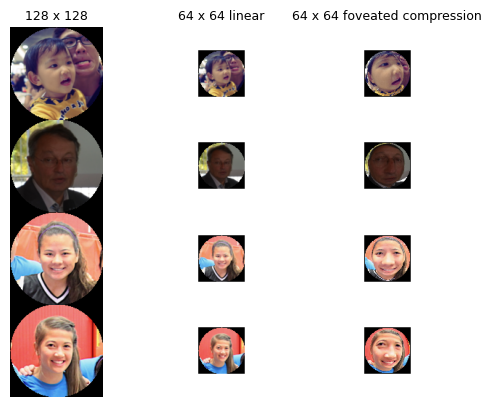

In [ ]:
# plot side by side
titles = ['128 x 128', '64 x 64 linear', '64 x 64 foveated compression']

fig, ax = plt.subplots(4,3)
# no whitespace
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(3):
    for j in range(4):
        ax[j,i].imshow(example_images[i][j].permute(1,2,0).cpu())
        if j == 0:
            ax[j,i].set_title(titles[i], fontsize=9)
        ax[j,i].axis('off')
plt.show()

# Test

In [76]:
experiment = '64x64lin'

cfg = config[experiment]

In [77]:
# Load datasets
testset = local_datasets.get_lapa_dataset(cfg, split='test')

# Show an example batch
batch = next(iter(DataLoader(testset, batch_size=4)))

In [78]:
models = init_training.get_models(cfg)

models['encoder'].load_state_dict(torch.load(cfg['save_path'] + 'checkpoints/final_encoder.pth'))
models['decoder'].load_state_dict(torch.load(cfg['save_path'] + 'checkpoints/final_decoder.pth'))

<All keys matched successfully>

In [79]:
# The forward function
training_pipeline = init_training.get_training_pipeline(cfg)

forward = training_pipeline['forward']
compound_loss_func = training_pipeline['compound_loss_func']

In [80]:
batch = next(iter(DataLoader(testset, batch_size=4)))

with torch.no_grad():
    model_output = forward(batch, models, cfg)
    loss = compound_loss_func(model_output)

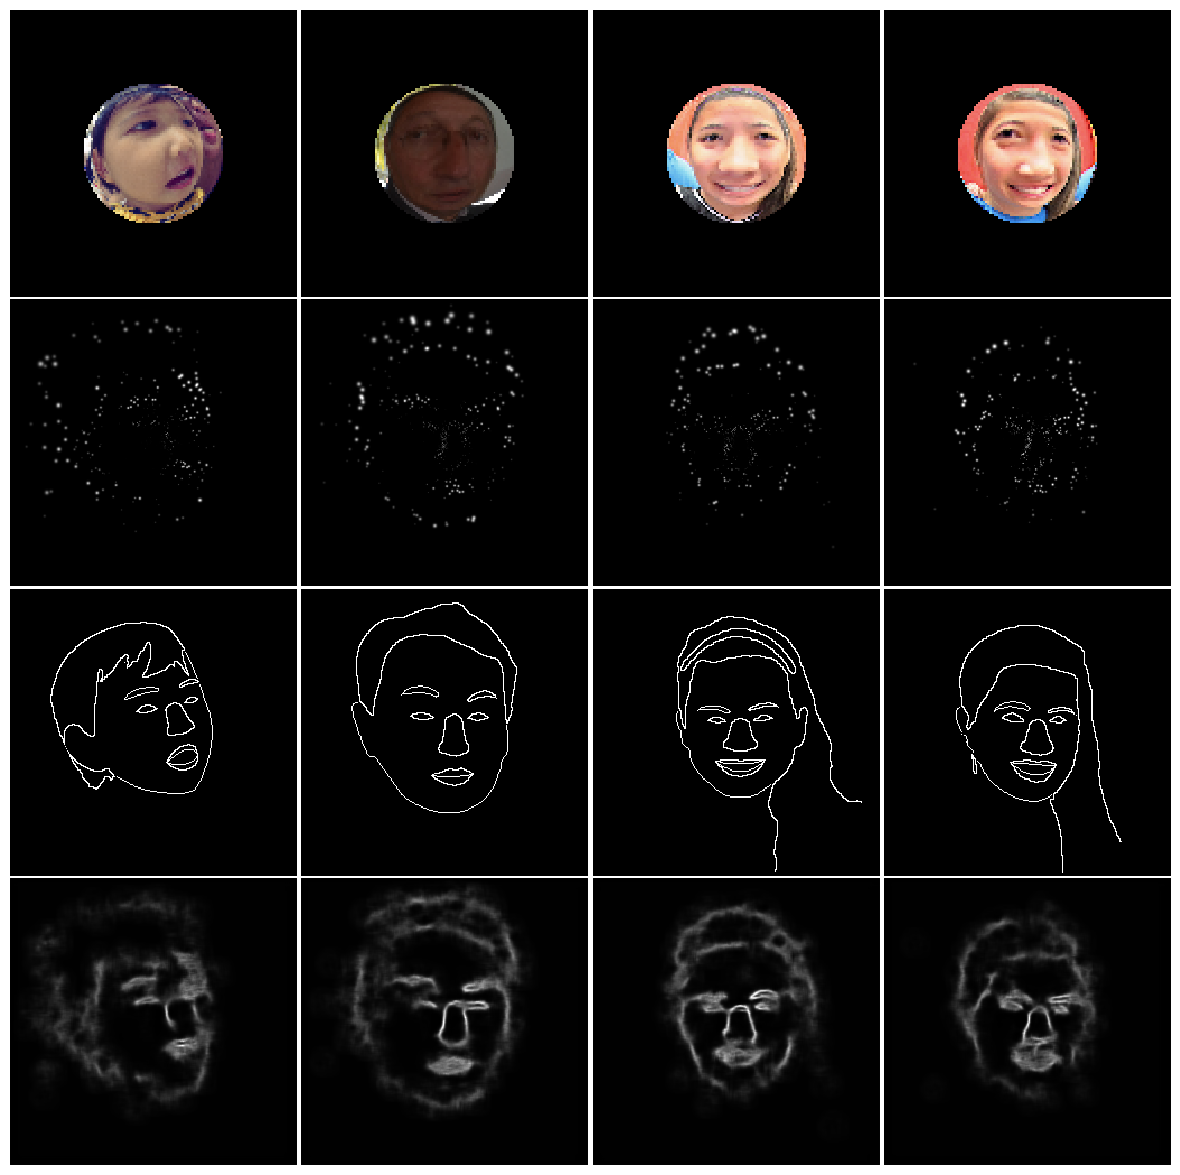

In [83]:
# Make pretty example of batch input, phosphenes, target, and reconstruction

# place input in 128 x 128 so it keeps it original scale
background = torch.zeros((batch['image'].shape[0], batch['image'].shape[1], 128, 128))
# place image of variable size in center of background
image_size = batch['image'].shape[-1]
background[:,:,64-image_size//2:64+image_size//2,64-image_size//2:64+image_size//2] = batch['image']
input = background


fig, axs = plt.subplots(4, 4, figsize=(15, 15))
# remove white space completely
fig.subplots_adjust(wspace=0.01, hspace=0.01)

for i in range(4):
    axs[0,i].imshow(input[i].permute(1,2,0).cpu(), interpolation='none')
    axs[0,i].axis('off')
    axs[1,i].imshow(model_output['phosphenes'][i][0].cpu(), cmap='gray', interpolation='none')
    axs[1,i].axis('off')
    axs[2,i].imshow(batch['contour'][i][0].cpu(), cmap='gray', interpolation='none')
    axs[2,i].axis('off')
    axs[3,i].imshow(model_output['reconstruction'][i].permute(1,2,0).cpu(), interpolation='none', cmap='gray')
    axs[3,i].axis('off')

plt.show()